# 1. 基于数据集多重抽样的分类器

将不同的分类器组合起来，这种组合结果称为集成方法(ensemble method)或者元算法(meta-algorithm)。

使用集成方法会有多种形式：可以是不同算法的集成，也可以是同一算法不同设置下的集成，还可以是数据集不同部分分配给不同分类器后的集成。

AdaBoost

优点：泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整

缺点：对离群点敏感

使用数据类型：数值型和标称型数据

## 1.1 bagging：基于数据随机重抽样的分类器构建方法

自举汇聚法(bootstrap aggregating)，也称bagging方法，是在从原始数据集选择S次后得到S个新数据集的一种技术。

新数据集和原始数据集的大小相等，每个数据集都是通过在原始数据集中随机选择一个样本来进行替换而得到的。

这里的替换意味着可以多次地选择同一个样本，这就允许新数据集中可以有重复的值，而原始数据集的某些值在新集合中不再出现。

在S个数据集建好以后，将某个学习算法分别作用于每个数据集就得到了S个分类器，对新数据分类时，选择分类器投票结果中最多的类别作为最后的分类结果。

还有更先进的bagging方法，如随机森林(random forest)。

## 1.2 boosting

boosting是一种与bagging很类似的技术，他们所使用的多个分类器的类型是一致的。他们的两个不同点：

其一，boosting方法的不同的分类器是通过串行训练来获得，每个新分类器都根据已训练出的分类器性能来进行训练。

boosting通过集中关注被已有分类器错分的数据来获得新的分类器。

其二，bagging中分类器权重是相等的，而boosting分类的结果是基于所有分类器的加权求和结果，因此分类器的权重并不相等。

其每个分类器的权重代表的是分类器在上一轮迭代中的成功度。

AdaBoost的一般流程

（1）收集数据：可以使用任何方法

（2）准备数据：依赖于所使用的弱分类器类型，本章使用的是单层决策树。第2-6章的任一分类器都可以充当弱分类器。作为弱分类器，简单的分类器效果更好。

（3）分析数据：可以使用任何方法

（4）训练算法：AdaBoost的大部分时间都用在训练上，分类器将多次在同一数据集上训练弱分类器

（5）测试算法：计算分类的错误率

（6）使用算法：同SVM一样，AdaBoost预测两个类别中的一个，如果要应用到多分类场合，需要像SVM一样进行修改

# 2. 训练算法：基于错误提升分类器的性能

AdaBoost是adaptive boosting(自适应boosting)的缩写，其运行过程如下：

训练数据中的每个样本，并赋予其一个权重，这些权重构成向量D，一开始，权重值相等。

首先在训练数据集上训练出一个弱分类器，并计算错误率，然后在同一数据集上再次训练弱分类器。

在分类器的第二次训练中，会调整每个样本的权重，其中，第一次分对的样本权重降低，而第一次分错的样本权重提高。

AdaBoost为每个分类器分配一个权重值alpha，用于最终结果的加权求和，这些alpha值是基于每个弱分类器的错误率进行计算的。

其中，错误率$\varepsilon$定义为：

$$ \varepsilon = \frac {未正确分类的样本数目} {所有样本数目} $$

而alpha的计算公式如下：

$$ \alpha = \frac {1} {2} \ln ( \frac {1 - \varepsilon} {\varepsilon} ) $$

如果某个样本被正确分类，那么样本权重更改为：

$$ D_i^{(t+1)} = \frac {D_i^{(t)}e^{-\alpha}} {Sum(D)} $$

如果某个样本被错分，那么样本权重更改为：

$$ D_i^{(t+1)} = \frac {D_i^{(t)}e^{\alpha}} {Sum(D)} $$

在计算出D之后，AdaBoost会进入下一轮迭代，直至训练错误率为0，或者弱分类器的数目达到用户指定的值。

# 3. 基于单层决策树构建弱分类器

单层决策树(decision stump，也称决策树桩)是一种简单的决策树，它仅基于单个特征来做决策。

In [1]:
from numpy import *

def loadSimpData():
    datmat = array([[1., 2.1], [2., 1.1], [1.3, 1.], [1., 1.], [2., 1.]])
    classLabels = [[1.0], [1.0], [-1.0], [-1.0], [1.0]]
    return datmat, classLabels

伪代码如下：

    将最小错误率minError设为正无穷
    对数据集中的每一个特征（第一层循环）：
        对每个步长（第二层循环）：
            对每个不等号（第三层循环）：
                建立一棵单层决策树并利用加权数据集对它进行测试
                如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
    返回最佳单层决策树

In [2]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

def buildStump(dataArr, classLabels, D):
    dataMatrix = array(dataArr)
    labelMat = array(classLabels)
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = zeros((m, 1))
    minError = inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = rangeMin + float(j) * stepSize
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = ones((m, 1))
                errArr[predictedVals == labelMat] = 0
                weightedError = dot(D.T, errArr)
                print('split: dim %d, thresh %.2f, thresh inequal: %s, the weighted error is %.3f' \
                       % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

datMat, classLabels = loadSimpData()
D = ones((5, 1)) / 5
buildStump(datMat, classLabels, D)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 array([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

# 4. 完整AdaBoost算法的实现

伪代码如下：

    对每次迭代：
        利用buildStump()函数找到最佳的单层决策树
        将最佳单层决策树加入到单层决策树组
        计算alpha
        计算新的权重向量D
        更新累计类别估计值
        如果错误率等于0.0，则退出循环

In [3]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = ones((m, 1)) / m
    aggClassEst = zeros((m, 1))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print('D:', D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print('classEst:', classEst.T)
        expon = classEst * (-1 * alpha * array(classLabels))
        D = D * exp(expon)
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print('aggClassEst:', aggClassEst.T)
        aggErrors = ones((m, 1)) * (sign(aggClassEst) != array(classLabels))
        errorRate = aggErrors.sum() / m
        print('total error:', errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr

classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50

In [4]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

# 5. 测试算法：基于AdaBoost的分类

每个弱分类器的结果以其对应的alpha值作为权重，所有弱分类器的结果加权求和得到最后结果。

In [5]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = array(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = zeros((m, 1))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return sign(aggClassEst)

datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)
adaClassify([[0, 0]], classifierArr)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50

array([[-1.]])

In [6]:
adaClassify([[5, 5], [0, 0]], classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


array([[ 1.],
       [-1.]])

# 6. 示例：在一个难数据集上应用AdaBoost

（1）收集数据：提供的文本文件

（2）准备数据：确保类别标签是+1和-1，而非1和0

（3）分析数据：手工检查数据

（4）训练算法：在数据上，利用adaBoostTrainDS()函数训练出一系列的分类器

（5）测试算法：有两个数据集。在不采用随机抽样的方法下，对AdaBoost和Logistic回归的结果进行完全对等的比较

（6）使用算法：观察该例子上的错误率

In [7]:
def loadDataSet(filename):
    dataMat = []
    labelMat = []
    with open(filename) as fr:
        numFeat = len(fr.readline().split('\t'))
        for line in fr.readlines():
            lineArr = []
            curline = line.strip().split('\t')
            for i in range(numFeat - 1):
                lineArr.append(float(curline[i]))
            dataMat.append(lineArr)
            labelMat.append([float(curline[-1])])
    return dataMat, labelMat

dataArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(dataArr, labelArr, 10)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.403
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.597
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.50

split: dim 8, thresh 2.10, thresh inequal: gt, the weighted error is 0.550
split: dim 8, thresh 2.40, thresh inequal: lt, the weighted error is 0.450
split: dim 8, thresh 2.40, thresh inequal: gt, the weighted error is 0.550
split: dim 8, thresh 2.70, thresh inequal: lt, the weighted error is 0.450
split: dim 8, thresh 2.70, thresh inequal: gt, the weighted error is 0.550
split: dim 8, thresh 3.00, thresh inequal: lt, the weighted error is 0.447
split: dim 8, thresh 3.00, thresh inequal: gt, the weighted error is 0.553
split: dim 9, thresh -0.50, thresh inequal: lt, the weighted error is 0.553
split: dim 9, thresh -0.50, thresh inequal: gt, the weighted error is 0.447
split: dim 9, thresh 0.00, thresh inequal: lt, the weighted error is 0.461
split: dim 9, thresh 0.00, thresh inequal: gt, the weighted error is 0.539
split: dim 9, thresh 0.50, thresh inequal: lt, the weighted error is 0.461
split: dim 9, thresh 0.50, thresh inequal: gt, the weighted error is 0.539
split: dim 9, thresh 1.

split: dim 7, thresh 2.40, thresh inequal: gt, the weighted error is 0.460
split: dim 7, thresh 3.00, thresh inequal: lt, the weighted error is 0.526
split: dim 7, thresh 3.00, thresh inequal: gt, the weighted error is 0.474
split: dim 7, thresh 3.60, thresh inequal: lt, the weighted error is 0.526
split: dim 7, thresh 3.60, thresh inequal: gt, the weighted error is 0.474
split: dim 7, thresh 4.20, thresh inequal: lt, the weighted error is 0.508
split: dim 7, thresh 4.20, thresh inequal: gt, the weighted error is 0.492
split: dim 7, thresh 4.80, thresh inequal: lt, the weighted error is 0.508
split: dim 7, thresh 4.80, thresh inequal: gt, the weighted error is 0.492
split: dim 7, thresh 5.40, thresh inequal: lt, the weighted error is 0.455
split: dim 7, thresh 5.40, thresh inequal: gt, the weighted error is 0.545
split: dim 7, thresh 6.00, thresh inequal: lt, the weighted error is 0.456
split: dim 7, thresh 6.00, thresh inequal: gt, the weighted error is 0.544
split: dim 8, thresh -0.3

split: dim 18, thresh 0.00, thresh inequal: gt, the weighted error is 0.502
split: dim 18, thresh 8.90, thresh inequal: lt, the weighted error is 0.454
split: dim 18, thresh 8.90, thresh inequal: gt, the weighted error is 0.546
split: dim 18, thresh 17.80, thresh inequal: lt, the weighted error is 0.456
split: dim 18, thresh 17.80, thresh inequal: gt, the weighted error is 0.544
split: dim 18, thresh 26.70, thresh inequal: lt, the weighted error is 0.456
split: dim 18, thresh 26.70, thresh inequal: gt, the weighted error is 0.544
split: dim 18, thresh 35.60, thresh inequal: lt, the weighted error is 0.456
split: dim 18, thresh 35.60, thresh inequal: gt, the weighted error is 0.544
split: dim 18, thresh 44.50, thresh inequal: lt, the weighted error is 0.456
split: dim 18, thresh 44.50, thresh inequal: gt, the weighted error is 0.544
split: dim 18, thresh 53.40, thresh inequal: lt, the weighted error is 0.455
split: dim 18, thresh 53.40, thresh inequal: gt, the weighted error is 0.545
sp

In [8]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
errArr = ones((66, 1))
errArr[prediction10 != array(testLabelArr)].sum()

[[ 0.45932045]
 [-0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [-0.45932045]
 [-0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [-0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]
 [ 0.45932045]]
[[ 0.7758

15.0

将弱分类器的数目设定为1到10000之间的几个不同数字，运行上述过程，得到下表：

| 分类器数目 | 训练错误率（%） | 测试错误率（%） |
| :-----: | :----: | :----: |
| 1 | 0.28 | 0.27 |
| 10 | 0.23 | 0.24 |
| 50 | 0.19 | 0.21 |
| 100 | 0.19 | 0.22 |
| 500 | 0.16 | 0.25 |
| 1000 | 0.14 | 0.31 |
| 10000 | 0.11 | 0.33 |

在第5章中，对同一数据集上采用Logistic回归得到的平均错误率为0.35。而采用AdaBoost，仅仅使用50个弱分类器，就达到了较高的性能。

观察上表的测试错误率一栏，可以发现测试错误率在达到了一个最小值后又开始上升了，这类现象称为过拟合(overfitting，也称过学习)。

有文献指出，对于表现较好的数据集，AdaBoost的测试错误率就会达到一个稳定值，并不会发生过拟合现象。

# 7. 非均衡分类问题

在之前的分类介绍中，我们假设所有类别的分类代价是一样的。例如第5章，我们构建了一个用于检测患疝病的马是否存活的系统。

假如对一匹马，我们预测其会死亡，那么马匹可能会被实施安乐死，那么如果我们的预测是错误的，我们将错杀一个如此昂贵的动物。

于是我们认识到，在大多数情况下，不同类别的分类代价并不相等。

## 7.1 其他分类性能度量指标：正确率、召回率及ROC曲线

在之前一直利用错误率来衡量分类器任务的成功程度，实际上，这样的度量错误掩盖了样例如何被分错的事实。

在机器学习中，有一个普遍适用的称为混淆矩阵(confusion matrix)的工具，它可以帮助人们更好地了解分类中的错误。

在一个二类问题中，如果将一个正例判为正例，称为真正例(True Positive，TP，也称真阳)

如果将一个反例判为反例，称为真反例(True Negative，TN，也称真阴)

如果将一个正例判为反例，称为伪反例(False Negative，FN，也称假阴)

如果将一个反例判为正例，称为伪正例(False Positive，FP，也称假阳)

|  | 预测结果 | +1 | -1 |
| :-----: | :----: | :----: | :----: |
| 真实结果 |  |  |
| +1 | | 真正例（TP） | 伪反例（FN） |
| -1 | | 伪正例（FP） | 真反例（TN） |

通过上表，可以定义更好的指标：

第一个指标是正确率(Precision)，它等于 TP/(TP + FP)，给出的是预测为正例的样本中真正正例的比例。

第二个指标是召回率(Recall)，它等于 TP/(TP + FN)，给出的是预测为正例的真实正例占所有正例的比例，在召回率很大的分类器中，真正判错的正例数目不多

另一个用于度量分类中的非均衡性的工具是ROC曲线(ROC curve)，ROC代表接收者操作特征(receiver operating characteristic)。

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.403
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.597
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.564
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.436
split: dim 0, thresh 1.50

split: dim 15, thresh 0.00, thresh inequal: lt, the weighted error is 0.426
split: dim 15, thresh 0.00, thresh inequal: gt, the weighted error is 0.574
split: dim 15, thresh 0.40, thresh inequal: lt, the weighted error is 0.426
split: dim 15, thresh 0.40, thresh inequal: gt, the weighted error is 0.574
split: dim 15, thresh 0.80, thresh inequal: lt, the weighted error is 0.426
split: dim 15, thresh 0.80, thresh inequal: gt, the weighted error is 0.574
split: dim 15, thresh 1.20, thresh inequal: lt, the weighted error is 0.455
split: dim 15, thresh 1.20, thresh inequal: gt, the weighted error is 0.545
split: dim 15, thresh 1.60, thresh inequal: lt, the weighted error is 0.455
split: dim 15, thresh 1.60, thresh inequal: gt, the weighted error is 0.545
split: dim 15, thresh 2.00, thresh inequal: lt, the weighted error is 0.454
split: dim 15, thresh 2.00, thresh inequal: gt, the weighted error is 0.546
split: dim 15, thresh 2.40, thresh inequal: lt, the weighted error is 0.454
split: dim 1

  -1.  1. -1.  1. -1. -1.  1.  1.  1. -1.]]
aggClassEst: [[ 0.95915367  1.0627529   0.12184787 -0.53511892  1.36215067  1.0627529
   0.42124565 -0.49739526 -0.12454694  0.42124565  0.4946962   1.36215067
   0.79409397  0.88570312 -0.49739526 -1.13048503  0.66602755  0.4946962
  -0.51124189 -0.12454694  1.36215067  1.0627529   0.95915367  0.88570312
   0.09797085  0.42124565  0.68990457  0.66602755  1.52721038 -1.13048503
   0.12184787  0.79409397  0.4946962  -0.49739526 -1.4298828   0.09797085
  -0.592577    1.0627529   0.09797085 -1.4298828   0.09797085  0.12184787
  -0.33233556 -0.66602755 -1.4298828  -1.13048503  1.0627529  -0.21184412
  -1.4298828   1.0627529   0.4946962   1.0627529   0.66602755 -0.21184412
   0.42124565  0.66602755 -0.12454694 -0.56242833 -1.4298828   1.0627529
   0.79409397 -0.23572114 -0.04678441  0.12184787  0.58630535  0.32606391
   1.36215067  0.33233556  1.0627529   0.0245203   1.36215067  0.09797085
  -0.18958     0.66602755  0.12184787  1.15436205  1.52721

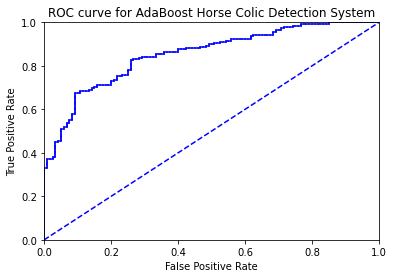

the Area Under the Curve is:  0.8538389513108606


In [9]:
import matplotlib.pyplot as plt

def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = ones((m, 1)) / m
    aggClassEst = zeros((m, 1))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print('D:', D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print('classEst:', classEst.T)
        expon = classEst * (-1 * alpha * array(classLabels))
        D = D * exp(expon)
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print('aggClassEst:', aggClassEst.T)
        aggErrors = ones((m, 1)) * (sign(aggClassEst) != array(classLabels))
        errorRate = aggErrors.sum() / m
        print('total error:', errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(array(classLabels) == 1.0)
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index][0] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print('the Area Under the Curve is: ', ySum * xStep)
    
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

上述绘出的ROC曲线中，横轴是伪正例的比例（假阳率=FP/(FP + TN)），而纵轴是真正例的比例（真阳率=TP/(TP + FN)）。虚线给出的是随机猜测的结果曲线。

在理想的情况下，最佳的分类器应该尽可能处于左上角。

对不同的ROC曲线进行比较的一个指标是曲线下的面积(Area Under the Curve，AUC)，AUC给出的是分类器的平均性能值。

ROC曲线不仅可以用于比较分类器，还可以基于成本效益(cost-versus-benefit)分析来做出决策。

## 7.2 基于代价函数的分类器决策控制

除了调节分类器的阈值之外，还有其他用于处理非均衡分类代价的方法，其中一种称为代价敏感的学习(cost-sensitive learning)。

|  | 预测结果 | +1 | -1 |
| :-----: | :----: | :----: | :----: |
| 真实结果 |  |  |
| +1 | | 0 | 1 |
| -1 | | 1 | 0 |

上表给出的是当前分类器的代价矩阵（代价不是0就是1），我们可以基于代价矩阵计算其总代价：$TP*0+FN*1+FP*1+TN*0$

|  | 预测结果 | +1 | -1 |
| :-----: | :----: | :----: | :----: |
| 真实结果 |  |  |
| +1 | | -5 | 1 |
| -1 | | 50 | 0 |

当然，也可以根据第二张表来计算总代价：$TP*(-5)+FN*1+FP*50+TN*0$

在分类算法中，有很多方法可以用来引入代价信息。在AdaBoost中，可以基于代价函数来调整错误权重向量D。

在朴素贝叶斯中，可以选择具有最小期望代价而不是最大概率的类别作为最后的结果。

在SVM中，可以在代价函数中对于不同的类别选择不同的参数C。

上述做法就会给较小类更多的权重，即在训练时，小类当中只允许更少的错误。

## 7.3 处理非均衡问题的数据抽样方法

还可以通过对分类器的训练数据进行改造，来针对非均衡问题调节分类器，比如欠抽样(undersampling)或者过抽样(oversampling)。

过抽样意味着复制样例，而欠抽样意味着删除样例。

通常会存在某个罕见的类别需要识别，例如信用卡欺诈中，正例类别属于罕见类别。可以从两个角度思考问题：

其一，是对反例类别进行欠抽样或者样例删除处理。在删除过程中，选择那些离决策边界较远的样例进行删除。

其二，也可以对正例类别进行过抽样，一种方法是加入已有数据点的插值点，但也会带来过拟合的问题。